In [328]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib.lines import Line2D
import os

# Carpeta en la que se ubican las tablas a integrar

In [329]:
print(os.getcwd())

C:\Users\alan.islas\ownCloud\Fuentes de tableros


# Carga de tablas 

In [330]:
# Load the XLSX files into Pandas dataframes
# La primera parte es la subcarpeta, después de la barra, /, el nombre del archivo
Inventario = pd.read_excel('Inventarios/20-04.xlsx', skiprows=2)
Ventas = pd.read_excel('Ventas/Ventas.xlsx', skiprows=2)
Utilidad = pd.read_excel('Ventas/Utilidad.xlsx', skiprows=2)
Cartera = pd.read_excel('Cartera/20-04.xlsx', skiprows=2)
Egresos = pd.read_excel('Egresos/Egresos.xlsx', skiprows=2)
Egresos_ = pd.read_excel('Egresos/Egresos_.xlsx', skiprows=2)
Pendiente = pd.read_excel('Suministro/Pendiente.xlsx', skiprows=2)
IQChemicals = pd.read_excel('IQChemicals/Otros.xlsx', skiprows=2)
IQChemicals_mp = pd.read_excel('IQChemicals/Materia_prima.xlsx', skiprows=2)
CxP = pd.read_excel('CxP/CxP.xlsx', skiprows=2)

# Tabla auxiliar para traducir unidades en costo
Pres_a_vol = pd.read_excel('Categorias/Presentacion_a_volumen.xlsx')
Item_a_producto = pd.read_excel('Categorias/Item_a_producto.xlsx')
Costos_unitarios = pd.read_excel('Costo_unitario/Costo.xlsx',skiprows=2)
Producto = pd.read_excel('Categorias/Producto.xlsx')


# Revisión de Tablas consideradas y columnas disponibles

Campos disponible:
Se muestra nombre de columna y primera fila,

In [331]:
#Muestra los headers de cada tabla:
print("---------Inventario---------")
print(Inventario.iloc[0,:])
print("---------Ventas---------")
print(Ventas.iloc[0,:])
print("---------Utilidad---------")
print(Utilidad.iloc[0,:])
print("---------Cartera---------")
print(Cartera.iloc[0,:])
print("---------Egresos_---------")
print(Egresos_.iloc[0,:])
print("---------Pendiente---------")
print(Pendiente.iloc[0,:])
print("---------IQChemicals---------")
print(IQChemicals.iloc[0,:])
print("---------IqChemicals_mp---------")
print(IQChemicals_mp.iloc[0,:])
print("---------CxP---------")
print(CxP.iloc[0,:])

---------Inventario---------
CATEGORIA                            ReactMaxx
GPO_INV                 AGROMIL PLUS REACTMAXX
PRESENTACION                              1X20
EMPRESA                                     MX
Número de artículo                    PLUS1X20
Sum of KL_INVENTARIO                     14900
KL_FORECAST                                  0
Sum of VENTAS_INV                 5239735.4006
VENTAS_FORECAST                            0.0
VARIACIONF                               14900
VALOR INVENTARIO                    666252.904
Name: 0, dtype: object
---------Ventas---------
RETENUM                                             RETENUM
Empresa                                                 CAC
Empresa Jerarquía - Zona Ranking_                 03 Zona 2
Empresa Jerarquía - RM/ REIQ_Ranking     08 Agrícola Piscis
Empresa Jerarquía - Cultivo_ranking               03 BANANO
ID_PRODUCTO                                AGGB10%4X5-CENCR
'Base'[Mes]                                   

# Limpieza y proceso de tablas para integrar la base de componentes financieros

##### La hoja de inventario IqChemicals, tiene dos tablas. Para el análisis, se consolidan en una:

In [332]:
IQChemicals_mp_otros = pd.concat([IQChemicals,IQChemicals_mp])

Cartera, se desglosa en Vencida y corriente

In [333]:
Cartera['ESTADO'] = np.where(Cartera['ANTIGUEDAD'] == '  VENCIDA', 'VENCIDA', 'CORRIENTE')

Cartera_corriente = Cartera[Cartera['ESTADO'] == 'CORRIENTE']
Cartera_vencida = Cartera[Cartera['ESTADO'] == 'VENCIDA']

In [334]:
#Inventario, incluir columna de ABC

Item_a_ABC = Item_a_producto.groupby(['Item','ABC']).size().reset_index()
Inventario = Inventario.rename(columns = {'Número de artículo':'Item'})
Inventario = Inventario.merge(Item_a_ABC, how = 'left', on = 'Item')

In [335]:
#Ventas e utilidad, incluir columna de categoría

#Hoja de producto a horizonte y categoría, se agrupa en producto y categoría p.ej. Plus es Cito
Producto = Producto.groupby(['Producto_Ranking','Respaldo categorías']).size().reset_index()

#Homologación de nombres
#Quitar primeras tres letras y poner en mayúsculas p.ej. 01 Agromil Plus ReactMaxx a AGROMIL PLUS REACTMAXX
Producto['Producto_Ranking'] = Producto['Producto_Ranking'].str.upper().str[3:]
Ventas['Producto_Ranking'] = Ventas['Producto_Ranking'].str[3:]
Utilidad['Producto_Ranking'] = Utilidad['Producto_Ranking'].str[3:]


Limpieza de homógos
JUNIPERUS no es igual que JUNÍPERUS... LPG 456 REACTMAXX, no es igual que LPG 456 -REACTMAXX...
La siguiente sección incluye algunos homólogos para que todos las filas crucen:

In [336]:
# Listado de productos que no cruzaron originalmente (Limpieza de homólogos)
Homologos_adicionales = pd.DataFrame({
    'Producto_Ranking': ['JUNIPERUS STRESSOFF', 'SPROUD MAX', 'LPG 456 - REACTMAXX', 'AGROPLEXBMO STRESSOFF', 
                'KIT-CALIDAD-IQC', 'KIT-ESTRUCTURAL-IQC', 'OTROS'],
    'Respaldo categorías': ['Bioestimulante', 'Cito', 'Cito', 'Bioestimulante', 
                 'Bioestimulante', 'Cito', 'Bioestimulante']
})

# Agregar Homologos_adicionales a tabla Producto:
Producto = pd.concat([Producto,Homologos_adicionales], ignore_index=True)



In [337]:
# Inclusión de columna categorías (Cito, Raíz, Bioestimulante...) en hoja de Ventas e Utilidad
Ventas = Ventas.merge(Producto, on = 'Producto_Ranking', how = 'left')
Utilidad = Utilidad.merge(Producto, on = 'Producto_Ranking', how = 'left')

In [338]:
#Pendiente, incluir columna de categoría
Item_a_categoría = Item_a_producto.groupby(['Item','Categoría']).size().reset_index()
Pendiente = Pendiente.rename(columns = {'ITEMNMBR':'Item'})
Pendiente = Pendiente.merge(Item_a_categoría, how = 'left', on = 'Item')

In [339]:
#IQChemicals_homologación de categorías

# Para facilitar la lectura, se homologan algunos campos
IQChemicals_mp_otros['ALMACEN_'] = np.where(IQChemicals_mp_otros['ALMACEN'].isin(['ALMACEN DE PRODUCTO TERMINADO CHEMICALS', 'PRODUCTO TERMINADO TLAXCALA']),
                                              'PRODUCTO TERMINADO',
                                              IQChemicals_mp_otros['ALMACEN'])

# Indice de tablas

In [340]:
#df - Ventas
#df1 - Utilidad
#df2 - Inventario
#df3 - Cartera_vencida
#df4 - Egresos
#df5 - Pendiente
#df6 - Costo
#df7 - Inventario IQC
#df8 - Cartera_corriente
#df9 - CxP
#df10 - Solicitado

# Homologación de nombres de columnas

In [341]:
#Ventas 2023, valores superiores a cero, renombrar columnas
Ventas = Ventas.rename(columns={
       'Empresa Jerarquía - Zona Ranking_':'Zona',
       'Empresa Jerarquía - RM/ REIQ_Ranking':'RM',
       'Empresa Jerarquía - Cultivo_ranking':'Cultivo',
       'ID_PRODUCTO':'Item', 
       "'Base'[Mes]'":"Mes",
       'Ver selección':'Ventas',
       'Respaldo categorías':'Nivel 2'
                        }
               )
Ventas = Ventas[Ventas['Ventas'] > 0]

In [342]:
#Utilidad 2023, renombrar columnas
Utilidad = Utilidad.rename(columns={
       'Empresa Jerarquía - Zona Ranking_':'Zona',
       'Empresa Jerarquía - RM/ REIQ_Ranking':'RM',
       'Empresa Jerarquía - Cultivo_ranking':'Cultivo',
       'ID_PRODUCTO':'Item', 
       "'Base'[Mes]'":"Mes",
       'Ver selección':'Utilidad',
       'Respaldo categorías':'Nivel 2'
                        }
               )
#Filtros de Utilidad 2023, valores superiores a cero
Utilidad = Utilidad[Utilidad['Utilidad'] > 0]

In [343]:

#Inventario, renombrar columnas
Inventario = Inventario.rename(columns = {
    'EMPRESA':'Empresa',
    'VALOR INVENTARIO':'Inventario_valor',
    'Número de artículo':'Item',
    'ABC':'Nivel 2'
    
                                        }
                              )
#Filtros de Inventario, valores superiores a uno, 

Inventario = Inventario[Inventario['Inventario_valor'] > 0]

In [344]:
#Cartera vencida, renombrar columnas
Cartera_vencida = Cartera_vencida.rename(columns = {
    "'VW_CxC_COM_V4'[EMPRESA]":"Empresa",
    "Sum of TOTAL":"Cartera_vencida",
    "ANTIGUEDAD":"Nivel 2"
                                        }
                              )
#Filtros de Cartera, valores superiores a uno, 

Cartera_vencida = Cartera_vencida[Cartera_vencida['Cartera_vencida'] > 0]

In [345]:
#Cartera_corriente, renombrar columnas
Cartera_corriente = Cartera_corriente.rename(columns = {
    "'VW_CxC_COM_V4'[EMPRESA]":"Empresa",
    "Sum of TOTAL":"Cartera_corriente",
    "ANTIGUEDAD":"Nivel 2"
                                        }
                              )
#Filtros de Cartera_corriente, valores superiores a uno, 

Cartera_corriente = Cartera_corriente[Cartera_corriente['Cartera_corriente'] > 0]

In [346]:
#Egresos, renombrar columnas
Egresos_ = Egresos_.rename(columns = {
    "NIVEL4":"Empresa",
    "Sum of MONTO":"Egresos_monto",
    "NIVEL2":"Nivel 2"
                                        }
                              )
#Filtros de Egresos, valores superiores a uno, 

Egresos_ = Egresos_[Egresos_['Egresos_monto'] > 0]
Egresos_ = Egresos_[Egresos_['FUENTE'] == "REAL"]

In [347]:
#Pendiente, renombrar columnas
Pendiente = Pendiente.rename(columns = {
    "EMPRESA":"Empresa",
    "Sum of PENDIENTE":"Unidades",
    "PRESENTACION":"Presentación",
    "Categoría":"Nivel 2",
    "Sum of SOLICITADO":"Unidades_"
                                        }
                              )
#Filtros de Egresos, valores superiores a uno, 


Formulaciones_a_excluir = ['AGE-21', 'AABC-22', 'ARP4-20', 'AC GL-22']
Pendiente = Pendiente[~Pendiente['FORMULACION'].isin(Formulaciones_a_excluir)]

In [348]:
#Pres_a_vol, NO requiere renombrar columnas
#Pres_a_vol.columns 

Listado de cols:
'Presentación', 'Vol aux'

In [349]:
#Costos_unitarios, renombrar columnas
Costos_unitarios = Costos_unitarios.rename(columns = {
    "PRESENTACION":"Presentación"
                                        }
                              )
#Filtros de Costos_unitarios, valores superiores a uno, 

Costos_unitarios = Costos_unitarios[Costos_unitarios['Sum of K/L'] > 0]

In [350]:
#Costos_unitarios, renombrar columnas
IQChemicals_mp_otros = IQChemicals_mp_otros.rename(columns = {
    "EMPRESA":"Empresa",
    "VALOR INVENTARIO":"Inventario_IQC_Valor",
    "ALMACEN_":"Nivel 2"
                                        }
                              )
#Filtros de Costos_unitarios, valores superiores a uno, 

IQChemicals_mp_otros = IQChemicals_mp_otros[IQChemicals_mp_otros['Inventario_IQC_Valor'] > 0]

In [351]:
#CxP, renombrar columnas
CxP = CxP.rename(columns = {
    "EMPRESA":"Empresa",
    "TOTAL":"CxP",
    "RUBRO":"Nivel 2"
                                        }
                              )
#Filtros de Costos_unitarios, valores superiores a uno, 

CxP = CxP[CxP['CxP'] > 0]

#### Tabla auxiliar para pasar de unidades a costo, para calcular valor de Pendiente por entregar y Valor de "Solicitado".

In [352]:
#Costo por formulación y presentación
Costos_unitarios = Costos_unitarios.groupby(['FORMULACION','Presentación'])['COSTOUNITREAL.'].mean().reset_index()

In [353]:
# Costos NO incluidos en tablero.
new_data = pd.DataFrame({
    'FORMULACION': ['APLG-21', 'BRXCO-21', 'AV5G-22', 'AV5G-22', 'BTR-22'],
    'Presentación': ['1X200', '12X1', '1X20', '4X5', '4X5'],
    'COSTOUNITREAL.': [20, 70, 80, 80, 200]
})

# Se consolida tabla para que no haya valores en blanco al cruzar con Pendiente
Costos_unitarios = pd.concat([Costos_unitarios, new_data], ignore_index=True)


In [354]:
#Factor de volumenn por presentación
Pres_a_vol_ = Pres_a_vol.groupby(['Presentación'])['Vol aux'].mean().reset_index()

In [355]:
#Unidades a volumen
Pendiente = Pendiente.merge(Pres_a_vol_, on = 'Presentación', how = 'left')
Pendiente['Volumen'] = Pendiente['Vol aux']*Pendiente['Unidades']
Pendiente['Volumen_'] = Pendiente['Vol aux']*Pendiente['Unidades_']
# Volumen a costo
Pendiente = Pendiente.merge(Costos_unitarios, on = ['FORMULACION', 'Presentación'], how = 'left')
Pendiente['Pendiente_valor'] = Pendiente['Volumen']*Pendiente['COSTOUNITREAL.']
Pendiente['Pendiente_solicitado'] = Pendiente['Volumen_']*Pendiente['COSTOUNITREAL.']
Pendiente.to_csv('Pend_vs_Sol.csv')

# Agrupar componentes financieros por empresa

In [356]:
# group Ventas por empresa
df = Ventas.groupby(['Empresa','Nivel 2'])['Ventas'].sum().reset_index()
df['Fuente'] = "Ventas"

In [357]:
# group Utilidad por empresa
df1 = Utilidad.groupby(['Empresa','Nivel 2'])['Utilidad'].sum().reset_index()
df1['Fuente'] = "Utilidad"

In [358]:
# group Inventario por empresa
df2 = Inventario.groupby(['Empresa','Nivel 2'])['Inventario_valor'].sum().reset_index()
df2['Fuente'] = "Inventario_valor"
df2 = df2.rename(columns = {'Inventario_valor':'Valor'})

In [359]:
# group Cartera por empresa
df3 = Cartera_vencida.groupby(['Empresa','Nivel 2'])['Cartera_vencida'].sum().reset_index()
df3['Fuente'] = "Cartera_vencida"
df3 = df3.rename(columns = {'Cartera_vencida':'Valor'})

In [360]:
# group Egresos por empresa
df4 = Egresos_.groupby(['Empresa','Nivel 2'])['Egresos_monto'].sum().reset_index()
df4['Fuente'] = "Egresos_monto"
df4 = df4.rename(columns = {'Egresos_monto':'Valor'})

In [361]:
# group Pendiente por empresa
df5 = Pendiente.groupby(['Empresa','Nivel 2'])['Pendiente_valor'].sum().reset_index()
df5['Fuente'] = "Pendiente"
df5 = df5.rename(columns = {'Pendiente_valor':'Valor'})

In [362]:
# group Solicitado por empresa
df10 = Pendiente.groupby(['Empresa','Nivel 2'])['Pendiente_solicitado'].sum().reset_index()
df10['Fuente'] = "Solicitado"
df10 = df10.rename(columns = {'Pendiente_solicitado':'Valor'})

#### A partir de la tabla de Utilidad y Ventas, se genera una nueva  tabla "Costo"

In [363]:
# Combinar Utilidad y Ventas
df_merged = pd.merge(df, df1, on=['Empresa', 'Nivel 2'], how='left')


# Calcular Costo como diferencia de Ventas e Utilidad
df_merged['Costo'] = df_merged['Ventas'] - df_merged['Utilidad']

# Agrupar Costo por Empresa
df6 = df_merged.groupby(['Empresa','Nivel 2'])['Costo'].sum().reset_index()
df6['Fuente'] = "Costo"
df6 = df6.rename(columns = {'Costo':'Valor'})

#### Agregar columna Fuente en Ventas e Utilidad;
Se agregó después porque esas columnas iban a utilizarse para crear la tabla de costos en el paso previo

In [364]:
df_ = df.rename(columns = {'Ventas':'Valor'})
df1_ = df1.rename(columns = {'Utilidad':'Valor'})

##### Inventario IQC valor

In [365]:
# group Inventario IQC por empresa
df7 = IQChemicals_mp_otros.groupby(['Empresa','Nivel 2'])['Inventario_IQC_Valor'].sum().reset_index()
df7['Fuente'] = "Inventario_IQC_Valor"
df7 = df7.rename(columns = {'Inventario_IQC_Valor':'Valor'})

In [366]:
# group Cartera corriente
df8 = Cartera_corriente.groupby(['Empresa','Nivel 2'])['Cartera_corriente'].sum().reset_index()
df8['Fuente'] = "Cartera_corriente"
df8 = df8.rename(columns = {'Cartera_corriente':'Valor'})


In [367]:
# group CxP
df9 = CxP.groupby(['Empresa','Nivel 2'])['CxP'].sum().reset_index()
df9['Fuente'] = "CxP"
df9 = df9.rename(columns = {'CxP':'Valor'})

# Componentes financieros consolidados

In [368]:
dfs = [df_, df1_, df2, df3, df4, df5, df6, df7, df8, df9, df10]
cols = ['Empresa', 'Nivel 2', 'Fuente', 'Valor']
df_merged = pd.concat(dfs, axis=0)



# Categorías de componentes

In [369]:
# Define the conditions and categories
conditions = [df_merged['Fuente'].isin(['Ventas', 'Utilidad']),
    df_merged['Fuente'].isin(['Egresos_monto', 'Costo', 'CxP']),
    df_merged['Fuente'].isin(['Cartera_vencida', 'Cartera_corriente','Inventario_valor', 'Pendiente','Inventario_IQC_Valor']),
    df_merged['Fuente'].isin(['Solicitado'])
]

categories = ['01 Ingresos','02 Egresos','03 Inventario y Cartera','Sol']

# Apply the conditions and categories to create a new "Category" column
df_merged['Categoria'] = np.select(conditions, categories)

# Exportar tabla para uso en tableros o tablas dinámicas

In [370]:
df_merged['Nivel 2'] = df_merged['Nivel 2'].replace(['Nutrición', 'Otro', 'Maquila', 'Coadyuvante'], 'Otros')


In [371]:
# Remove Empresas ASESORIA and ENFOKT
df_merged = df_merged[~df_merged['Empresa'].isin(['ASESORIA', 'ENFOKT'])]

In [372]:
df_merged.to_csv('Componentes_financieros_nivel_2.csv')

# Componentes consolidados

In [373]:
# group by "Component" and "Category", format the "Value" column as currency, and sum the values
df_merged['Valor (M)'] = df_merged['Valor'].apply(lambda x: x / 1000000)

# group by "Component" and "Category", format the "Value" column as currency, and sum the values
Componentes = df_merged.groupby(['Categoria', 'Fuente'])['Valor (M)'].apply(lambda x: x.sum()).reset_index()

# pivot the table to put the "Category" values as columns
Componentes_ = Componentes.pivot(index='Fuente', columns='Categoria', values='Valor (M)')
Componentes_ = Componentes_.fillna(0)

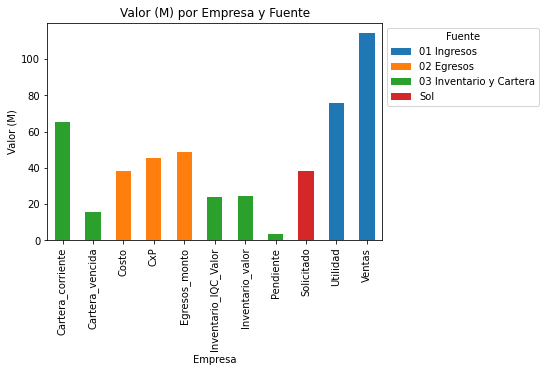

In [374]:

# create a stacked bar plot of the DataFrame
ax = Componentes_.plot.bar(stacked=True)

# customize the plot labels and legend
ax.set_xlabel('Empresa')
ax.set_ylabel('Valor (M)')
ax.set_title('Valor (M) por Empresa y Fuente')
ax.legend(title='Fuente', bbox_to_anchor=(1.0, 1.0))


In [375]:
# format the currency columns
for col in Componentes_.columns:
    Componentes_[col] = Componentes_[col].apply(lambda x: "${:,.1f}".format(x))

# print the result
print(Componentes_)

Categoria            01 Ingresos 02 Egresos 03 Inventario y Cartera    Sol
Fuente                                                                    
Cartera_corriente           $0.0       $0.0                   $65.1   $0.0
Cartera_vencida             $0.0       $0.0                   $15.4   $0.0
Costo                       $0.0      $38.5                    $0.0   $0.0
CxP                         $0.0      $45.3                    $0.0   $0.0
Egresos_monto               $0.0      $48.7                    $0.0   $0.0
Inventario_IQC_Valor        $0.0       $0.0                   $23.7   $0.0
Inventario_valor            $0.0       $0.0                   $24.7   $0.0
Pendiente                   $0.0       $0.0                    $3.7   $0.0
Solicitado                  $0.0       $0.0                    $0.0  $38.3
Utilidad                   $75.7       $0.0                    $0.0   $0.0
Ventas                    $114.2       $0.0                    $0.0   $0.0


In [376]:
### Resumen de categorías consideradas

In [377]:
# create a dictionary to map the old values to the new values
fuente_dict = {'Ventas': 'Vent', 'Utilidad': 'Uti', 'Inventario_valor': 'Inv', 'Cartera_vencida': 'Cart Ok', 'Egresos_monto': 'Gasto', 'Pendiente': 'PPE', 'Costo': 'Cost', 'Inventario_IQC_Valor': 'Inv IQC', 'Cartera_corriente': 'Cart Ok', 'CxP': 'CxP', 'Solicitado':'Sol'}
fuente_dict_ = {'01 Ingresos': 'Ut y V', '02 Egresos': 'Egr', '03 Inventario y Cartera': 'Inv y Cart', 'Sol':'S'}

# replace the old values with the new values using the dictionary
df_merged['Fuente'] = df_merged['Fuente'].replace(fuente_dict)
df_merged['Categoria'] = df_merged['Categoria'].replace(fuente_dict_)

Detalle = df_merged.groupby(['Fuente', 'Nivel 2','Categoria'])['Valor (M)'].apply(lambda x: x.sum()).reset_index()

# pivot the table to put the "Category" values as columns
Detalle_ = Detalle.pivot(index=['Fuente','Nivel 2'], columns='Categoria', values='Valor (M)')

Detalle_ = Detalle_.fillna(0)
# format the currency columns
for col in Detalle_.columns:
    Detalle_[col] = Detalle_[col].apply(lambda x: "${:,.1f}".format(x))

# print the result
print(Detalle_.head(60))
Detalle_.to_csv('Resumen_comp_financieros.csv')

Categoria                              Egr Inv y Cart      S Ut y V
Fuente  Nivel 2                                                    
Cart Ok   VENCIDA                     $0.0      $15.4   $0.0   $0.0
         EN EL MES                    $0.0      $30.5   $0.0   $0.0
        A 30 DIAS                     $0.0      $26.3   $0.0   $0.0
        A 60 DIAS                     $0.0       $6.7   $0.0   $0.0
        A 90 +                        $0.0       $1.6   $0.0   $0.0
Cost    Bioestimulante                $7.8       $0.0   $0.0   $0.0
        Cito                          $8.2       $0.0   $0.0   $0.0
        GA                            $7.9       $0.0   $0.0   $0.0
        Otros                         $5.8       $0.0   $0.0   $0.0
        Raíz/ suelo                   $8.8       $0.0   $0.0   $0.0
CxP     CONSUMIBLES                  $11.2       $0.0   $0.0   $0.0
        GASTOS FIJOS                 $11.3       $0.0   $0.0   $0.0
        INVERSIONES                   $0.1      

In [378]:
####Resumen de categorías por empresa

In [379]:
# group by "Component" and "Category", format the "Value" column as currency, and sum the values
Componentes_p_Emp = df_merged.groupby(['Fuente', 'Empresa'])['Valor (M)'].apply(lambda x: x.sum()).reset_index()

# pivot the table to put the "Category" values as columns
Componentes_p_Emp_ = Componentes_p_Emp.pivot(index='Empresa', columns='Fuente', values='Valor (M)')

In [380]:
Componentes_p_Emp_ = Componentes_p_Emp_.fillna(0)

# format the currency columns
for col in Componentes_p_Emp_.columns:
    Componentes_p_Emp_[col] = Componentes_p_Emp_[col].apply(lambda x: "${:,.1f}".format(x))

# print the result
Componentes_p_Emp_ = Componentes_p_Emp_.fillna(0)
print(Componentes_p_Emp_)

Fuente  Cart Ok   Cost    CxP Gasto   Inv Inv IQC   PPE    Sol    Uti   Vent
Empresa                                                                     
CAC       $18.5   $7.8   $1.5  $5.4  $1.9    $0.0  $0.0   $0.8   $8.2  $16.0
CHEMI      $0.0   $0.0  $20.3  $5.0  $0.0   $23.7  $0.0   $0.0   $0.0   $0.0
INT        $5.0   $1.3   $1.0  $1.6  $0.1    $0.0  $0.0   $0.6   $2.4   $3.7
IQCHEM     $8.5   $2.2   $0.6  $3.9  $8.5    $0.0  $0.1   $1.2   $5.1   $7.3
LASA       $0.0   $0.0   $3.1  $8.0  $0.0    $0.0  $0.0   $0.0   $0.0   $0.0
MX        $41.8  $26.1   $3.2  $9.8  $9.7    $0.0  $3.6  $34.4  $54.7  $80.8
RETENUM    $0.0   $0.0  $10.3  $9.6  $0.0    $0.0  $0.0   $0.0   $0.0   $0.0
SACH       $0.0   $0.0   $3.2  $0.0  $0.0    $0.0  $0.0   $0.0   $0.0   $0.0
SUD        $6.7   $1.0   $2.1  $5.4  $4.4    $0.0  $0.0   $1.3   $5.2   $6.2


In [381]:
# Remove Fuente 'Vent'
df_merged = df_merged[df_merged['Fuente'] != 'Vent']




In [382]:
from matplotlib.ticker import MultipleLocator

# Group by Empresa, Categoria, and Fuente, and aggregate by Valor
df_grouped = df_merged.groupby(['Empresa', 'Categoria', 'Fuente'])['Valor'].sum().reset_index()

# Pivot the data to create a multi-index dataframe
df_pivot = df_grouped.pivot(index=['Empresa', 'Categoria'], columns='Fuente', values='Valor')

# Format the values in millions with 2 decimals
df_pivot = df_pivot.apply(lambda x: x/1000000).round(2)

# Define the order of the companies
company_order = ['MX', 'CAC', 'IQCHEM', 'SUD', 'INT', 'CHEMI', 'RETENUM', 'LASA', 'SACH']




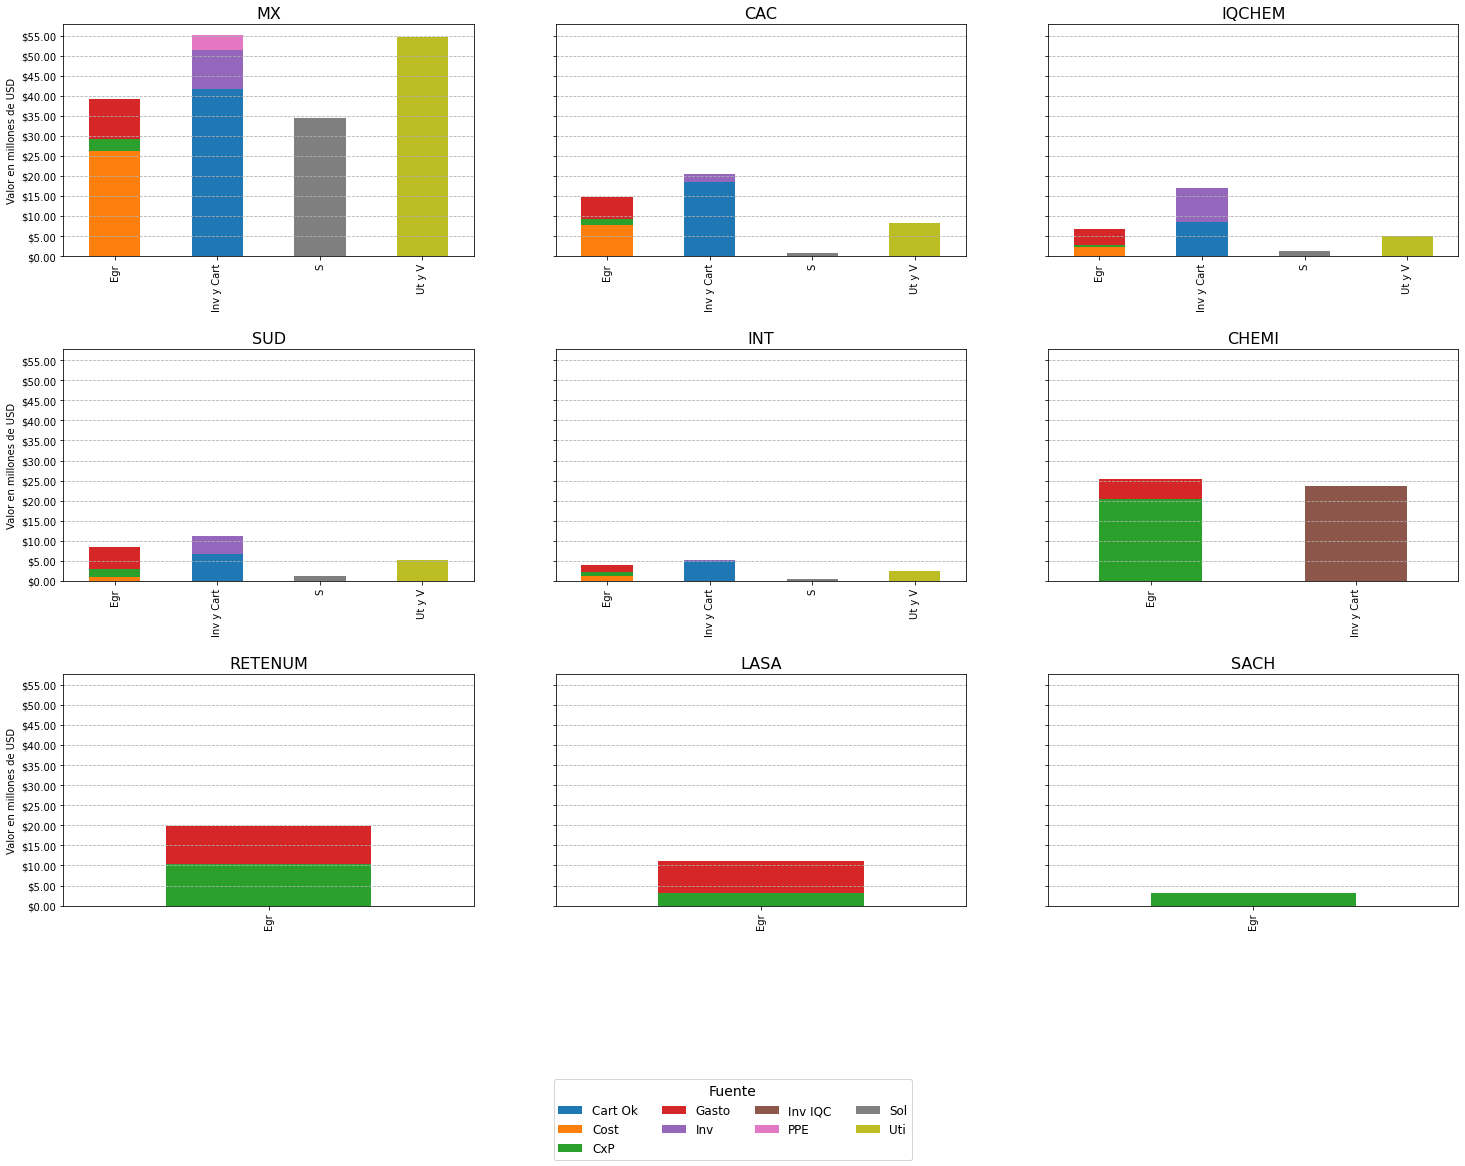

S = Solicitado; Ut y V = Utilidad y Ventas; Egr = Egresos; Inv y Cart = Inventario y Cartera


In [383]:
import matplotlib as mpl

# Define the order of the companies
company_order = ['MX', 'CAC', 'IQCHEM', 'SUD', 'INT', 'CHEMI', 'RETENUM', 'LASA', 'SACH']

# Create a figure with subplots for each company
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(25, 18), sharey=True)

# Iterate over each company and subplot
for i, empresa in enumerate(company_order):
    ax = axs.flatten()[i]
    df_pivot.loc[empresa].plot(kind='bar', stacked=True, ax=ax)
    ax.set_title(empresa, fontsize=16)
    ax.set_xlabel('')
    ax.set_ylabel('Valor en millones de USD')
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.2f}'))
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
    ax.grid(axis='y', linestyle='--')
    ax.legend().set_visible(False)
    
# Remove the remaining subplots
for i in range(len(company_order), len(axs.flatten())):
    fig.delaxes(axs.flatten()[i])

# Add a subplot for the legend and display it
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, fontsize=12, title='Fuente', title_fontsize=14)
plt.subplots_adjust(bottom=0.2)    

# Adjust the spacing between subplots
fig.subplots_adjust(hspace=0.4)

# Display the plot
plt.savefig('prueba.png')
plt.show()
print("S = Solicitado; Ut y V = Utilidad y Ventas; Egr = Egresos; Inv y Cart = Inventario y Cartera")

